In [1]:
# SETUP AND IMPORTS
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
import warnings
import sys
import os

# --- PyTorch and Sklearn Imports --
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, Dataset, SubsetRandomSampler
from sklearn.model_selection import KFold
from sklearn.metrics import average_precision_score
from tqdm.notebook import tqdm
from einops import rearrange
from timm.models.layers import DropPath, to_2tuple, trunc_normal_

# --- TensorFlow for Data Loading ONLY --
import tensorflow as tf

# --- CRITICAL FIX v2: Isolate TensorFlow to CPU without hiding the GPU from PyTorch ---
try:
    physical_devices = tf.config.list_physical_devices()
    cpus = [d for d in physical_devices if d.device_type == 'CPU']
    tf.config.set_visible_devices(cpus)
    print("✅ TensorFlow successfully configured to use CPU only.")

    # --- VERIFICATION STEP ---
    if not tf.config.list_physical_devices('GPU'):
        print("   - Confirmed: TensorFlow does not see the GPU.")
    else:
        print("   - ⚠️ WARNING: TensorFlow can still see the GPU. Conflicts may occur.")

    if torch.cuda.is_available():
        print("✅ PyTorch can see and use the GPU.")
        print(f"   - GPU Device Name: {torch.cuda.get_device_name(0)}")
    else:
        print("   - ❌ CRITICAL WARNING: PyTorch cannot see the GPU. Training will be on CPU.")

except Exception as e:
    print(f"An error occurred during device configuration: {e}")


warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

# Define data directory
DATA_DIR = Path("/kaggle/input/ndws_western_dataset")
print(f"📁 Data directory: {DATA_DIR}")
print(f"📂 Directory exists: {DATA_DIR.exists()}")

# --- CORRECTED TFRecord PARSING FUNCTION --
def parse_tfrecord_flexible(example):
    """
    Parse TFRecord with the CORRECT feature description.
    """
    feature_description = {}

    expected_features = [
        'elevation', 'NDVI', 'erc', 'pr', 'pdsi', 'population',
        'impervious', 'water', 'tmp_day', 'tmp_75', 'wind_avg', 'wind_75',
        'wdir_wind', 'wdir_gust', 'gust_med', 'avg_sph', 'bi', 'chili',
        'fuel1', 'fuel2', 'fuel3', 'viirs_PrevFireMask', 'viirs_FireMask'
    ]

    for feat in expected_features:
        feature_description[feat] = tf.io.FixedLenFeature([64, 64], tf.float32)

    parsed_features = tf.io.parse_single_example(example, feature_description)
    return parsed_features

print("\n✅ Setup complete!")

/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2225: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2225: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` 

✅ TensorFlow successfully configured to use CPU only.
   - ⚠️ WARNING: TensorFlow can still see the GPU. Conflicts may occur.
✅ PyTorch can see and use the GPU.
   - GPU Device Name: Tesla P100-PCIE-16GB
📁 Data directory: /kaggle/input/ndws_western_dataset
📂 Directory exists: True

✅ Setup complete!


In [2]:
!pip install timm -q

In [3]:
# --- UPDATED VISUALIZATION FUNCTION (WITH SAVE CAPABILITY) ---

def visualize_fire_predictions_pytorch(model, X_test, y_test, num_samples=4, save_path=None):
    """
    Visualize fire prediction results and optionally save the plot to a file.
    """
    if len(X_test) == 0:
        print("❌ No test samples available for visualization")
        return

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()

    X_test_subset = X_test[:num_samples]
    y_test_subset = y_test[:num_samples]

    with torch.no_grad():
        X_test_tensor = torch.from_numpy(np.transpose(X_test_subset, (0, 3, 1, 2))).float().to(device)
        predictions_tensor = model(X_test_tensor)
        predictions = np.transpose(predictions_tensor.cpu().numpy(), (0, 2, 3, 1))

    fig, axes = plt.subplots(num_samples, 3, figsize=(15, 5 * num_samples))
    if num_samples == 1:
        axes = axes.reshape(1, -1)

    for i in range(num_samples):
        input_fire = X_test_subset[i, :, :, 0]
        true_fire = y_test_subset[i, :, :, 0]
        pred_fire = predictions[i, :, :, 0]

        axes[i, 0].imshow(input_fire, cmap='Reds', vmin=0, vmax=1)
        axes[i, 0].set_title(f'Sample {i+1}: Input Fire (t)')
        axes[i, 0].axis('off')

        axes[i, 1].imshow(true_fire, cmap='Reds', vmin=0, vmax=1)
        axes[i, 1].set_title(f'True Fire (t+1)')
        axes[i, 1].axis('off')

        axes[i, 2].imshow(pred_fire, cmap='Reds', vmin=0, vmax=1)
        axes[i, 2].set_title(f'Predicted Fire (t+1)')
        axes[i, 2].axis('off')

    plt.tight_layout()

    # <<< NEW: Save the figure if a path is provided >>>
    if save_path:
        try:
            plt.savefig(save_path, bbox_inches='tight', dpi=150)
            print(f"✅ Visualization saved to '{save_path}'")
        except Exception as e:
            print(f"⚠️ Could not save visualization. Error: {e}")

    plt.show() # Display the plot after saving

    # Return the prediction statistics so they can be saved to the results file
    stats = {
        "true_fire_pixels": np.sum(y_test_subset > 0.1),
        "predicted_fire_pixels": np.sum(predictions > 0.5),
        "average_prediction_confidence": np.mean(predictions)
    }

    # Print statistics to the notebook
    print(f"\n📊 PREDICTION STATISTICS:")
    print(f"🔥 True fire pixels in displayed samples: {stats['true_fire_pixels']}")
    print(f"🎯 Predicted fire pixels (threshold > 0.5): {stats['predicted_fire_pixels']}")
    print(f"📈 Average prediction confidence: {stats['average_prediction_confidence']:.4f}")

    return stats

# --- NEW FUNCTION TO SAVE ALL RESULTS TO A TEXT FILE ---
def save_results_to_file(model_name, cv_results, viz_stats, file_path="model_results.txt"):
    """
    Saves the cross-validation and visualization statistics for a model to a text file.
    """
    mean_ap = np.mean(cv_results)
    std_ap = np.std(cv_results)

    try:
        with open(file_path, 'a') as f: # 'a' for append mode
            f.write("="*70 + "\n")
            f.write(f"MODEL: {model_name}\n")
            f.write("="*70 + "\n\n")

            f.write("--- Cross-Validation Summary ---\n")
            f.write(f"Mean Average Precision (AP): {mean_ap:.4f} ± {std_ap:.4f}\n")
            f.write(f"Individual Fold AP Scores: {[f'{score:.4f}' for score in cv_results]}\n\n")

            if viz_stats:
                f.write("--- Visualization Sample Statistics ---\n")
                f.write(f"True Fire Pixels: {viz_stats['true_fire_pixels']}\n")
                f.write(f"Predicted Fire Pixels (>0.5): {viz_stats['predicted_fire_pixels']}\n")
                f.write(f"Average Prediction Confidence: {viz_stats['average_prediction_confidence']:.4f}\n\n\n")

        print(f"✅ Results for '{model_name}' appended to '{file_path}'")
    except Exception as e:
        print(f"⚠️ Could not save results to file. Error: {e}")

print("✅ Visualization and results-saving functions are ready!")

✅ Visualization and results-saving functions are ready!


# 🔥 SPATIAL FIRE SPREAD PREDICTION WITH Swin-Unet ARCHITECTURE

**CRITICAL FIX**: This section implements proper spatial fire spread prediction using:
- ✅ **Raw spatial features** (64x64 grids) - NOT statistical summaries
- ✅ **All 106 input features** as spatial inputs
- ✅ **Swin-Unet architecture** for pixel-level fire spread prediction
- ✅ **Temporal prediction**: PrevFireMask(t) → FireMask(t+1)
- ✅ **Research-based approach** following wildfire prediction literature

**Key Point**: The data pipeline remains identical to the previous versions. The core change is the model architecture, which now uses Swin Transformer blocks for both the encoder and decoder.

In [4]:
# --- FINAL DATA PROCESSOR: COMBINING TIME-SERIES AND CURRENT DAY DATA ---

class CombinedFireDataProcessor:
    """
    Processes data to give the model the best of both worlds:
    - Historical environmental context (from the past)
    - Current day fire and environmental state
    """
    def __init__(self, data_dir=DATA_DIR, num_timesteps=4):
        self.data_dir = data_dir
        self.num_timesteps = num_timesteps # Past days of environmental data
        self.environmental_features = [
            'elevation', 'NDVI', 'erc', 'pr', 'pdsi', 'population',
            'impervious', 'water', 'tmp_day', 'tmp_75', 'wind_avg', 'wind_75',
            'wdir_wind', 'wdir_gust', 'gust_med', 'avg_sph', 'bi', 'chili',
            'fuel1', 'fuel2', 'fuel3'
        ]

    def load_raw_spatial_data(self, max_sequences=None):
        """
        Load and create the ultimate time-series sequences.
        Input X: viirs_PrevFireMask(t) + Env Features(t-4 to t-1) + Env Features(t)
        Target Y: viirs_FireMask(t+1)
        """
        print("🔥 Loading RAW SPATIAL DATA for COMBINED (Time-Series + Current Day) prediction...")
        
        tfrecord_files = list(self.data_dir.glob("*.tfrecord"))
        if not tfrecord_files:
            print("❌ No TFRecord files found!")
            return None, None
        print(f"📁 Found {len(tfrecord_files)} TFRecord files")

        all_samples_flat = []
        # Load all daily snapshots into one list
        for file_path in tfrecord_files:
            dataset = tf.data.TFRecordDataset(str(file_path))
            for raw_record in dataset:
                try:
                    parsed_sample = parse_tfrecord_flexible(raw_record)
                    sample_data = {name: tensor.numpy() for name, tensor in parsed_sample.items()}
                    if 'viirs_PrevFireMask' in sample_data and 'viirs_FireMask' in sample_data:
                        all_samples_flat.append(sample_data)
                except Exception as e:
                    print(f"❗️ FAILED TO PROCESS A RECORD in {file_path.name}. Error: {e}")
                    break
            else: continue
            break
        
        print(f"  ...Loaded {len(all_samples_flat)} total individual samples.")

        if not all_samples_flat:
             print("❌ No valid samples were loaded.")
             return None, None

        # --- COMBINED SLIDING WINDOW LOGIC ---
        spatial_inputs, spatial_targets = [], []
        # Total window size = num_timesteps (past env) + 1 (current day) + 1 (target day)
        sequence_len = self.num_timesteps + 2
        
        for i in range(len(all_samples_flat) - sequence_len):
            if max_sequences and len(spatial_inputs) >= max_sequences:
                break

            # Define the time windows
            past_environmental_sequence = all_samples_flat[i : i + self.num_timesteps] # t-4 to t-1
            current_day_sample = all_samples_flat[i + self.num_timesteps]              # day 't'
            next_day_sample = all_samples_flat[i + self.num_timesteps + 1]           # day 't+1'

            # --- Assemble the Input Tensor (X) ---
            input_features = []
            
            # 1. Add the fire mask from the CURRENT day (t)
            input_features.append(current_day_sample['viirs_PrevFireMask'].reshape(64, 64, 1))

            # 2. Add environmental features from the PAST days (t-4 to t-1)
            for past_sample in past_environmental_sequence:
                for feature_name in self.environmental_features:
                    if feature_name in past_sample:
                        input_features.append(past_sample[feature_name].reshape(64, 64, 1))
            
            # 3. Add environmental features from the CURRENT day (t)
            for feature_name in self.environmental_features:
                 if feature_name in current_day_sample:
                    input_features.append(current_day_sample[feature_name].reshape(64, 64, 1))

            # --- Assemble the Target Tensor (y) ---
            target_mask = next_day_sample['viirs_FireMask'].reshape(64, 64, 1)

            if len(input_features) > 1:
                spatial_inputs.append(np.concatenate(input_features, axis=2))
                spatial_targets.append(target_mask)

        if not spatial_inputs:
            print("❌ Could not create any sequences with the combined logic!")
            return None, None
            
        X_spatial = np.array(spatial_inputs, dtype=np.float32)
        y_spatial = np.array(spatial_targets, dtype=np.float32)

        print(f"\n✅ COMBINED DATA LOADING COMPLETE")
        print(f"📊 Spatial Input Shape: {X_spatial.shape}")
        print(f"📊 Spatial Target Shape: {y_spatial.shape}")
        return X_spatial, y_spatial

In [5]:
# --- DATASET CLASS AND NORMALIZATION (UNCHANGED FROM PREVIOUS NOTEBOOKS) ---
import random
from torch.utils.data import Dataset, SubsetRandomSampler

class WildfireDataset(Dataset):
    """
    PyTorch Dataset for loading wildfire sequences "just-in-time" from TFRecords.
    This avoids loading the entire dataset into memory.
    """
    def __init__(self, data_dir, num_timesteps=4, max_sequences=None, normalization_stats=None):
        self.data_dir = data_dir
        self.num_timesteps = num_timesteps
        self.normalization_stats = normalization_stats
        self.sequence_len = self.num_timesteps + 2 # Total daily records needed for one sequence

        self.environmental_features = [
            'elevation', 'NDVI', 'erc', 'pr', 'pdsi', 'population', 'impervious', 'water',
            'tmp_day', 'tmp_75', 'wind_avg', 'wind_75', 'wdir_wind', 'wdir_gust', 'gust_med',
            'avg_sph', 'bi', 'chili', 'fuel1', 'fuel2', 'fuel3'
        ]

        print("🔥 Initializing WildfireDataset: Building sequence index...")
        self.tfrecord_files = sorted(list(self.data_dir.glob("*.tfrecord")))
        self.index = self._build_index()

        if max_sequences is not None and max_sequences < len(self.index):
            print(f" M Randomly sampling {max_sequences} sequences from the full dataset.")
            self.index = random.sample(self.index, max_sequences)

        print(f"✅ Index created. Dataset contains {len(self.index)} sequences.")

    def _build_index(self):
        """ Scans TFRecords and creates a master list of all valid sequence start points. """
        index = []
        for file_path in self.tfrecord_files:
            # Get the total number of records in the file quickly
            num_records = sum(1 for _ in tf.data.TFRecordDataset(str(file_path)))

            # A sequence can start at 'i' if there are enough records after it
            for i in range(num_records - self.sequence_len + 1):
                index.append((str(file_path), i)) # Store (filepath, record_offset)
        return index

    def __len__(self):
        return len(self.index)

    def __getitem__(self, idx):
        """ Loads and processes a single sequence from disk on demand. """
        file_path, record_offset = self.index[idx]

        # Use tf.data to efficiently skip to the required records
        dataset = tf.data.TFRecordDataset(file_path)
        raw_records = dataset.skip(record_offset).take(self.sequence_len)

        # Load the small set of daily samples needed for this one sequence
        daily_samples = []
        for raw_record in raw_records:
            parsed_sample = parse_tfrecord_flexible(raw_record)
            sample_data = {name: tensor.numpy() for name, tensor in parsed_sample.items()}
            daily_samples.append(sample_data)

        # --- Assemble the Input and Target Tensors (same logic as before) ---
        past_environmental_sequence = daily_samples[0 : self.num_timesteps]
        current_day_sample = daily_samples[self.num_timesteps]
        next_day_sample = daily_samples[self.num_timesteps + 1]

        input_features = []
        input_features.append(current_day_sample['viirs_PrevFireMask'].reshape(64, 64, 1))
        for past_sample in past_environmental_sequence:
            for feature_name in self.environmental_features:
                if feature_name in past_sample:
                    input_features.append(past_sample[feature_name].reshape(64, 64, 1))
        for feature_name in self.environmental_features:
             if feature_name in current_day_sample:
                input_features.append(current_day_sample[feature_name].reshape(64, 64, 1))
        
        # Concatenate and transpose for PyTorch (C, H, W)
        x = np.concatenate(input_features, axis=2).astype(np.float32)
        x = np.transpose(x, (2, 0, 1))

        # Get target mask and transpose
        y = next_day_sample['viirs_FireMask'].reshape(64, 64, 1).astype(np.float32)
        y = (np.transpose(y, (2, 0, 1)) > 0.1).astype(np.float32)

        x_tensor = torch.from_numpy(x)
        y_tensor = torch.from_numpy(y)

        # Apply normalization if stats are provided
        if self.normalization_stats is not None:
            means = self.normalization_stats['means']
            stds = self.normalization_stats['stds']
            x_tensor = (x_tensor - means) / stds

        return x_tensor, y_tensor

def calculate_normalization_stats(dataset, num_samples=500):
    """ Calculates mean and std for normalization on a subset of the data. """
    print(f"📊 Calculating normalization statistics on {num_samples} random samples...")

    num_samples = min(num_samples, len(dataset))
    sampler = SubsetRandomSampler(random.sample(range(len(dataset)), num_samples))
    loader = DataLoader(dataset, batch_size=32, sampler=sampler, num_workers=2)

    channels_sum, channels_squared_sum, num_batches = 0, 0, 0
    for inputs, _ in tqdm(loader, desc="Calculating Stats"):
        channels_sum += torch.mean(inputs, dim=[0, 2, 3])
        channels_squared_sum += torch.mean(inputs**2, dim=[0, 2, 3])
        num_batches += 1

    mean = channels_sum / num_batches
    std = (channels_squared_sum / num_batches - mean**2)**0.5
    std[std == 0] = 1

    stats = {'means': mean.reshape(-1, 1, 1), 'stds': std.reshape(-1, 1, 1)}
    print("✅ Normalization stats calculated.")
    return stats

In [6]:
# --- PYTORCH SWIN-UNET ARCHITECTURE (ALIGNED WITH PAPER, USING PRE-TRAINING) ---
# This new implementation replaces the previous custom SwinUnet class.
# It uses the 'timm' library to load a Swin Transformer pre-trained on ImageNet as the encoder.

from einops import rearrange
from timm.models.layers import DropPath, to_2tuple, trunc_normal_
from timm.models.swin_transformer import SwinTransformer
import torch
import torch.nn as nn
import torch.nn.functional as F
import timm # Make sure timm is imported

# --- HELPER MODULES (UNCHANGED FROM YOUR NOTEBOOK) ---
# These are required for the decoder part of the network.
class Mlp(nn.Module):
    def __init__(self, in_features, hidden_features=None, out_features=None, act_layer=nn.GELU, drop=0.):
        super().__init__()
        out_features = out_features or in_features
        hidden_features = hidden_features or in_features
        self.fc1 = nn.Linear(in_features, hidden_features)
        self.act = act_layer()
        self.fc2 = nn.Linear(hidden_features, out_features)
        self.drop = nn.Dropout(drop)

    def forward(self, x):
        x = self.fc1(x); x = self.act(x); x = self.drop(x)
        x = self.fc2(x); x = self.drop(x)
        return x

class PatchExpand(nn.Module):
    def __init__(self, input_resolution, dim, norm_layer=nn.LayerNorm):
        super().__init__()
        self.input_resolution = input_resolution
        self.dim = dim
        self.expand = nn.Linear(dim, 2 * dim, bias=False)
        self.norm = norm_layer(dim // 2)

    def forward(self, x):
        H, W = self.input_resolution
        x = self.expand(x)
        B, L, C = x.shape
        assert L == H * W, "Input feature has wrong size"
        x = x.view(B, H, W, C)
        x = rearrange(x, 'b h w (p1 p2 c_out) -> b (h p1) (w p2) c_out', p1=2, p2=2, c_out=C // 4)
        x = x.view(B, -1, C // 4)
        x = self.norm(x)
        return x

class FinalPatchExpand_X4(nn.Module):
    def __init__(self, input_resolution, dim, norm_layer=nn.LayerNorm):
        super().__init__()
        self.input_resolution = input_resolution
        self.dim = dim
        self.expand = nn.Linear(dim, 16 * dim, bias=False)
        self.norm = norm_layer(dim)

    def forward(self, x):
        H, W = self.input_resolution
        x = self.expand(x)
        B, L, C = x.shape
        assert L == H * W, "Input feature has wrong size"
        x = x.view(B, H, W, C)
        x = rearrange(x, 'b h w (p1 p2 c_out) -> b (h p1) (w p2) c_out', p1=4, p2=4, c_out=C // 16)
        x = self.norm(x)
        return x

# --- NEW PRE-TRAINED SWIN-UNET CLASS ---
class SwinUnet(nn.Module):
    def __init__(self, img_size=224, in_chans=106, num_classes=1, pretrained=True):
        super().__init__()
        self.num_classes = num_classes

        # 1. Load the pre-trained Swin Transformer from timm
        # This matches the 'swin-tiny-patch4-window7-224' model from the paper
        self.encoder = timm.create_model(
            'swin_tiny_patch4_window7_224',
            pretrained=pretrained,
            features_only=True, # This gives us intermediate features for skip connections
        )

        # 2. Modify the first layer (patch_embed) to accept 106 channels
        # We copy the weights from the original RGB layer and average them across the new channels.
        # This is a standard technique to preserve the pre-trained knowledge.
        original_patch_embed = self.encoder.patch_embed.proj
        new_patch_embed = nn.Conv2d(in_chans, original_patch_embed.out_channels,
                                    kernel_size=original_patch_embed.kernel_size,
                                    stride=original_patch_embed.stride,
                                    padding=original_patch_embed.padding)

        # Average the weights from the 3 RGB channels and repeat for all 106 input channels
        avg_weights = original_patch_embed.weight.data.mean(dim=1, keepdim=True)
        new_patch_embed.weight.data = avg_weights.repeat(1, in_chans, 1, 1)
        if original_patch_embed.bias is not None:
            new_patch_embed.bias.data = original_patch_embed.bias.data

        self.encoder.patch_embed.proj = new_patch_embed

        # --- Decoder (rebuilds the U-Net structure) ---
        encoder_dims = self.encoder.feature_info.channels() # e.g., [96, 192, 384, 768]

        self.decoder4 = nn.Sequential(
            nn.Conv2d(encoder_dims[3], encoder_dims[2], kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(encoder_dims[2]), nn.ReLU(inplace=True))
        self.decoder3 = nn.Sequential(
            nn.Conv2d(encoder_dims[2]*2, encoder_dims[1], kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(encoder_dims[1]), nn.ReLU(inplace=True))
        self.decoder2 = nn.Sequential(
            nn.Conv2d(encoder_dims[1]*2, encoder_dims[0], kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(encoder_dims[0]), nn.ReLU(inplace=True))
        self.decoder1 = nn.Sequential(
            nn.Conv2d(encoder_dims[0]*2, encoder_dims[0], kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(encoder_dims[0]), nn.ReLU(inplace=True))

        # --- Final Output Layer ---
        self.final_conv = nn.Sequential(
            nn.Conv2d(encoder_dims[0], 32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, num_classes, kernel_size=1),
        )

    # --- RECTIFIED FORWARD METHOD (FINAL v2) ---
    def forward(self, x):
        # Resize input from 64x64 to 224x224, as required by the pre-trained model
        x_resized = F.interpolate(x, size=(224, 224), mode='bilinear', align_corners=False)

        # --- Encoder Forward Pass ---
        # Get the feature maps at different stages for the skip connections
        features = self.encoder(x_resized)
        f1, f2, f3, f4 = features[0], features[1], features[2], features[3]

        # <<< --- THE CORRECT FIX IS HERE --- >>>
        # All feature maps from the timm encoder are in (B, H, W, C) format.
        # We must permute all of them to the PyTorch standard (B, C, H, W) format.
        f1 = f1.permute(0, 3, 1, 2) # B, 56, 56, 96  -> B, 96, 56, 56
        f2 = f2.permute(0, 3, 1, 2) # B, 28, 28, 192 -> B, 192, 28, 28
        f3 = f3.permute(0, 3, 1, 2) # B, 14, 14, 384 -> B, 384, 14, 14
        f4 = f4.permute(0, 3, 1, 2) # B, 7, 7, 768   -> B, 768, 7, 7
        # <<< --- END OF FIX --- >>>

        # --- Decoder Forward Pass (this part remains the same) ---
        d4 = self.decoder4(f4)
        d4_upsampled = F.interpolate(d4, scale_factor=2, mode='bilinear', align_corners=False)

        d3 = self.decoder3(torch.cat([d4_upsampled, f3], 1))
        d3_upsampled = F.interpolate(d3, scale_factor=2, mode='bilinear', align_corners=False)

        d2 = self.decoder2(torch.cat([d3_upsampled, f2], 1))
        d2_upsampled = F.interpolate(d2, scale_factor=2, mode='bilinear', align_corners=False)

        d1 = self.decoder1(torch.cat([d2_upsampled, f1], 1))

        # Upsample to the final output size (original 64x64)
        out = F.interpolate(d1, size=(64, 64), mode='bilinear', align_corners=False)
        out = self.final_conv(out)

        return torch.sigmoid(out)

# --- LOSS FUNCTION AND GENERIC TRAINING FUNCTION ---

# --- LOSS FUNCTION (UNCHANGED) ---
class BCEDiceLoss(nn.Module):
    def __init__(self, weight=0.5):
        super(BCEDiceLoss, self).__init__()
        self.weight = weight
    def forward(self, inputs, targets, smooth=1e-6):
        inputs_flat = inputs.view(-1); targets_flat = targets.view(-1)
        bce_loss = nn.BCELoss()(inputs_flat, targets_flat)
        intersection = (inputs_flat * targets_flat).sum()
        dice_score = (2. * intersection + smooth) / (inputs_flat.sum() + targets_flat.sum() + smooth)
        dice_loss = 1 - dice_score
        return self.weight * bce_loss + (1 - self.weight) * dice_loss

# --- GENERIC TRAINING FUNCTION (THIS IS THE MISSING FUNCTION) ---
def train_fire_model_cv_pytorch(dataset, model_class, model_args, n_splits=5, epochs=20, batch_size=4, checkpoint_path="model_checkpoint.pth"):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    use_gpu = torch.cuda.is_available()
    print(f"🚀 INITIATING TRAINING ON {device} WITH {n_splits}-FOLD CV")
    print(f"🎯 Main Metric: Average Precision (AP)")
    print("=" * 60)

    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    fold_ap_scores = []
    last_model = None
    start_fold = 0
    checkpoint = None

    if os.path.exists(checkpoint_path):
        try:
            checkpoint = torch.load(checkpoint_path, map_location=torch.device('cpu'))
            start_fold = checkpoint.get('fold', 0)
            if checkpoint.get('epoch', -1) == epochs - 1: start_fold += 1
            fold_ap_scores = checkpoint.get('fold_ap_scores', [])
            if start_fold > 0 and start_fold < n_splits:
                print(f"🔄 Resuming training from fold {start_fold + 1}")
        except Exception as e:
            print(f"⚠️ Could not load checkpoint: {e}. Starting from scratch.")
            checkpoint = None

    for fold, (train_idx, val_idx) in enumerate(kfold.split(dataset)):
        if fold < start_fold: continue

        print(f"\n========== FOLD {fold + 1}/{n_splits} ==========")
        train_sampler = SubsetRandomSampler(train_idx)
        val_sampler = SubsetRandomSampler(val_idx)

        train_loader = DataLoader(dataset, batch_size=batch_size, sampler=train_sampler, num_workers=2, pin_memory=use_gpu)
        val_loader = DataLoader(dataset, batch_size=batch_size, sampler=val_sampler, num_workers=2, pin_memory=use_gpu)

        model = model_class(**model_args).to(device)
        criterion = BCEDiceLoss(weight=0.5)
        optimizer = optim.Adam(model.parameters(), lr=1e-4)

        start_epoch = 0
        if checkpoint is not None and fold == checkpoint.get('fold', -1):
            try:
                model.load_state_dict(checkpoint['model_state_dict'])
                optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
                start_epoch = checkpoint.get('epoch', 0) + 1
                if start_epoch < epochs:
                    print(f"🔄 Resuming fold {fold+1} from epoch {start_epoch + 1}")
            except Exception as e:
                print(f"⚠️ Could not load state dicts from checkpoint: {e}. Starting fold from scratch.")
                start_epoch = 0

        print(f"🔥 STARTING TRAINING...")
        for epoch in range(start_epoch, epochs):
            model.train()
            progress_bar = tqdm(train_loader, desc=f"Epoch {epoch + 1}/{epochs}", leave=False)
            for inputs, labels in progress_bar:
                inputs, labels = inputs.to(device), labels.to(device)
                optimizer.zero_grad(); outputs = model(inputs); loss = criterion(outputs, labels)
                loss.backward(); optimizer.step()
                progress_bar.set_postfix(loss=f"{loss.item():.4f}")

            torch.save({'fold': fold, 'epoch': epoch, 'model_state_dict': model.state_dict(), 'optimizer_state_dict': optimizer.state_dict(), 'fold_ap_scores': fold_ap_scores}, checkpoint_path)

        model.eval(); all_preds, all_labels = [], []
        with torch.no_grad():
            for inputs, labels in tqdm(val_loader, desc="Validating", leave=False):
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                all_preds.append(outputs.cpu().numpy().flatten())
                all_labels.append(labels.cpu().numpy().flatten())
        
        if len(np.concatenate(all_labels)) > 0 and len(np.unique(np.concatenate(all_labels))) > 1:
            ap_score = average_precision_score(np.concatenate(all_labels), np.concatenate(all_preds))
            if len(fold_ap_scores) <= fold: fold_ap_scores.append(ap_score)
            else: fold_ap_scores[fold] = ap_score
            print(f"✅ Fold {fold + 1} Validation - AP: {ap_score:.4f}")
        else:
            print(f"⚠️ Fold {fold + 1} Validation - Could not compute AP. Not enough class diversity in labels.")

        last_model = model
        checkpoint = None 

    print("\n\n📊 CROSS-VALIDATION SUMMARY"); print("=" * 60)
    if fold_ap_scores: print(f"  - Mean AP ± Std Dev: {np.mean(fold_ap_scores):.4f} ± {np.std(fold_ap_scores):.4f}")
    if last_model:
        model_save_path = f"final_{model.__class__.__name__.lower()}.pth"
        torch.save(last_model.state_dict(), model_save_path)
        print(f"\n💾 Final model from last fold saved to '{model_save_path}'")
        if os.path.exists(checkpoint_path):
            os.remove(checkpoint_path)
            print(f"🗑️ Removed temporary checkpoint file: '{checkpoint_path}'")

    return last_model, fold_ap_scores

🔥 Initializing WildfireDataset: Building sequence index...
 M Randomly sampling 1 sequences from the full dataset.
✅ Index created. Dataset contains 1 sequences.
✅ Model configured: SwinUnet_Pretrained with 106 input channels.

--- Step 1: Preparing Dataset ---
🔥 Initializing WildfireDataset: Building sequence index...
 M Randomly sampling 100 sequences from the full dataset.
✅ Index created. Dataset contains 100 sequences.
📊 Calculating normalization statistics on 100 random samples...


Calculating Stats:   0%|          | 0/4 [00:00<?, ?it/s]

✅ Normalization stats calculated.
🔥 Initializing WildfireDataset: Building sequence index...
 M Randomly sampling 100 sequences from the full dataset.
✅ Index created. Dataset contains 100 sequences.

--- Step 2: Training SwinUnet_Pretrained ---
🚀 INITIATING TRAINING ON cuda WITH 3-FOLD CV
🎯 Main Metric: Average Precision (AP)

========== FOLD 1/3 ==========
🔥 STARTING TRAINING...


Epoch 1/25:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 2/25:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 3/25:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 4/25:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 5/25:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 6/25:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 7/25:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 8/25:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 9/25:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 10/25:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 11/25:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 12/25:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 13/25:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 14/25:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 15/25:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 16/25:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 17/25:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 18/25:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 19/25:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 20/25:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 21/25:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 22/25:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 23/25:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 24/25:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 25/25:   0%|          | 0/17 [00:00<?, ?it/s]

Validating:   0%|          | 0/9 [00:00<?, ?it/s]

✅ Fold 1 Validation - AP: 0.0821

========== FOLD 2/3 ==========
🔥 STARTING TRAINING...


Epoch 1/25:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 2/25:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 3/25:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 4/25:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 5/25:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 6/25:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 7/25:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 8/25:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 9/25:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 10/25:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 11/25:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 12/25:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 13/25:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 14/25:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 15/25:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 16/25:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 17/25:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 18/25:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 19/25:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 20/25:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 21/25:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 22/25:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 23/25:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 24/25:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 25/25:   0%|          | 0/17 [00:00<?, ?it/s]

Validating:   0%|          | 0/9 [00:00<?, ?it/s]

✅ Fold 2 Validation - AP: 0.0718

========== FOLD 3/3 ==========
🔥 STARTING TRAINING...


Epoch 1/25:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 2/25:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 3/25:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 4/25:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 5/25:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 6/25:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 7/25:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 8/25:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 9/25:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 10/25:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 11/25:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 12/25:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 13/25:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 14/25:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 15/25:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 16/25:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 17/25:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 18/25:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 19/25:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 20/25:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 21/25:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 22/25:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 23/25:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 24/25:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 25/25:   0%|          | 0/17 [00:00<?, ?it/s]

Validating:   0%|          | 0/9 [00:00<?, ?it/s]

✅ Fold 3 Validation - AP: 0.0619


📊 CROSS-VALIDATION SUMMARY
  - Mean AP ± Std Dev: 0.0719 ± 0.0082

💾 Final model from last fold saved to 'final_swinunet.pth'
🗑️ Removed temporary checkpoint file: 'swinunet_pretrained_checkpoint.pth'

🎉 SwinUnet_Pretrained TRAINING COMPLETED!

--- Step 3: Generating Visualizations and Saving Results for SwinUnet_Pretrained ---
✅ Visualization saved to 'swinunet_pretrained_predictions.png'


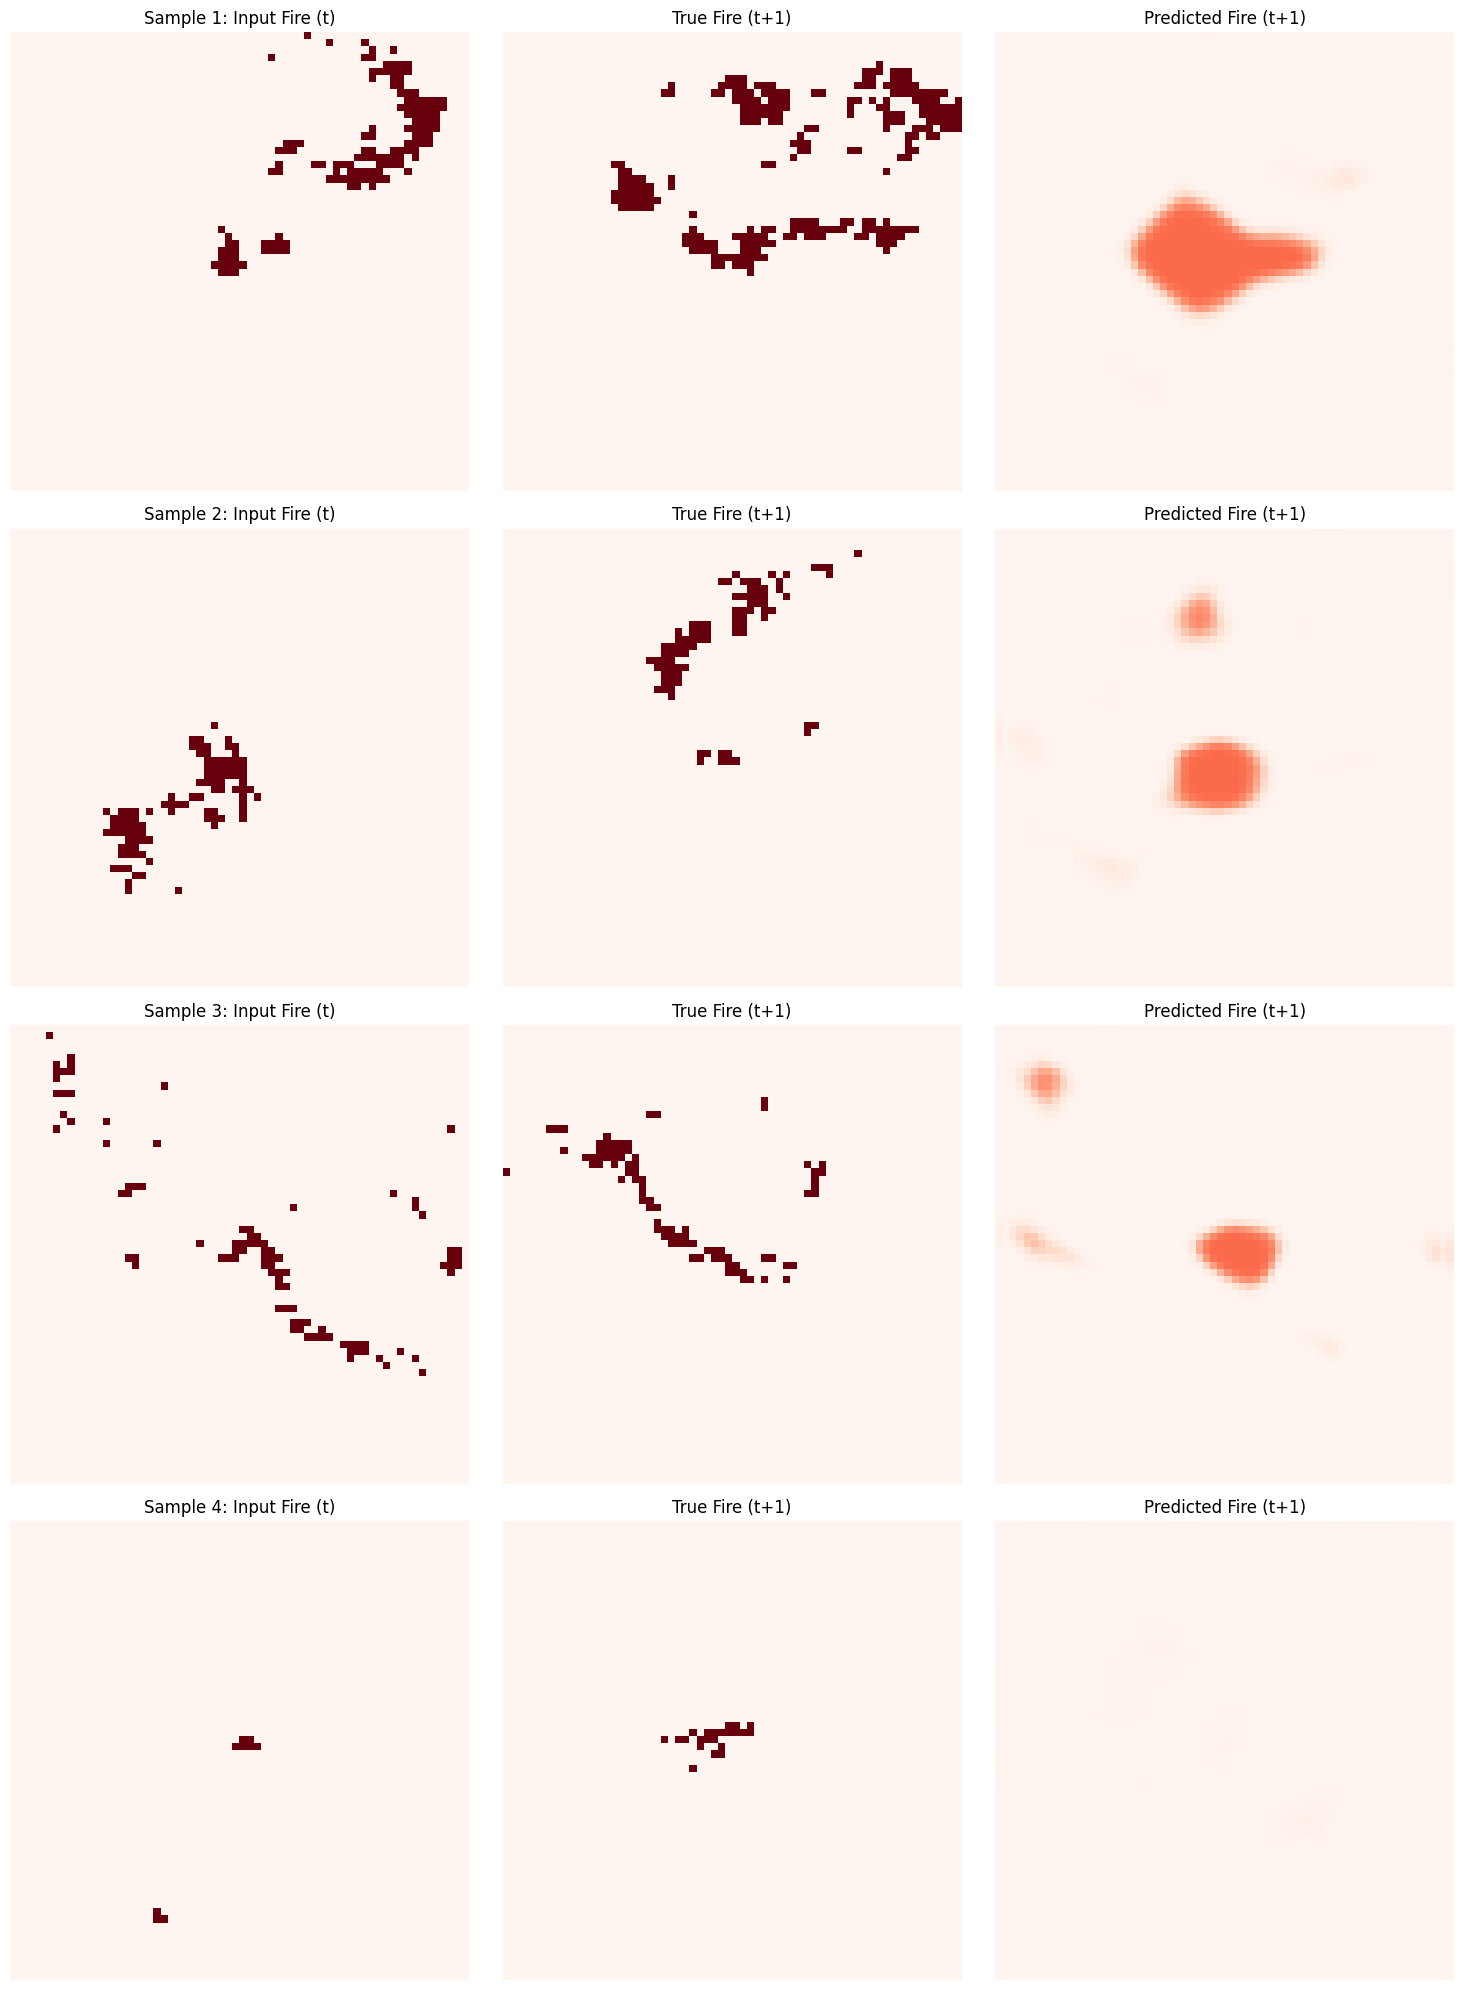


📊 PREDICTION STATISTICS:
🔥 True fire pixels in displayed samples: 457
🎯 Predicted fire pixels (threshold > 0.5): 0
📈 Average prediction confidence: 0.0157
✅ Results for 'SwinUnet_Pretrained' appended to 'model_results.txt'


In [7]:
# --- EXECUTION FOR THE COMBINED TIME-SERIES MODEL WITH SWIN-UNET --
# (Updated to use the new pre-trained model class)

# --- MODEL CONFIGURATION --
model_name = "SwinUnet_Pretrained" # Changed name for clarity
checkpoint_file = "swinunet_pretrained_checkpoint.pth"

# Get the number of input channels from a sample item
# (This part of your logic remains the same)
sample_x, _ = WildfireDataset(data_dir=DATA_DIR, max_sequences=1)[0]
num_input_channels = sample_x.shape[0]

# <<< CHANGE IS HERE >>>
# The detailed swinunet_args dictionary is no longer needed.
# The new class handles the architecture based on the 'swin_tiny' model.
# We just need to pass the number of input channels.
model_args = {
    'in_chans': num_input_channels,
    'num_classes': 1,
    'pretrained': True # Explicitly ask for pre-trained weights
}
print(f"✅ Model configured: {model_name} with {num_input_channels} input channels.")

# --- THE REST OF THE CELL REMAINS IDENTICAL TO YOURS ---

# 1. Initialize the Dataset (without loading all data into RAM)
print("\n--- Step 1: Preparing Dataset ---")
temp_dataset = WildfireDataset(data_dir=DATA_DIR, num_timesteps=4, max_sequences=100)
normalization_stats = calculate_normalization_stats(temp_dataset, num_samples=100)

full_dataset = WildfireDataset(
    data_dir=DATA_DIR,
    num_timesteps=4,
    max_sequences=100, # NOTE: For a real result, this must be much larger
    normalization_stats=normalization_stats
)

# 2. Train the Swin-Unet model
final_model_swinunet = None
cv_results_swinunet = []
viz_stats_swinunet = None

if len(full_dataset) > 0:
    print(f"\n--- Step 2: Training {model_name} ---")

    final_model_swinunet, cv_results_swinunet = train_fire_model_cv_pytorch(
        dataset=full_dataset,
        model_class=SwinUnet, # Uses the new SwinUnet class
        model_args=model_args, # Uses the simplified model_args
        n_splits=3,
        epochs=25, # Fine-tuning often requires fewer epochs
        batch_size=4,
        checkpoint_path=checkpoint_file
    )

    if cv_results_swinunet:
        print(f"\n🎉 {model_name} TRAINING COMPLETED!")
    else:
        print(f"❌ {model_name} training failed or was interrupted!")
else:
    print(f"❌ Cannot train model - dataset is empty!")

# 3. Visualization and Saving Results (This section remains the same)
if final_model_swinunet is not None:
    print(f"\n--- Step 3: Generating Visualizations and Saving Results for {model_name} ---")

    kfold = KFold(n_splits=3, shuffle=True, random_state=42)
    _, val_indices = list(kfold.split(full_dataset))[-1]

    num_viz_samples = min(4, len(val_indices))
    if num_viz_samples > 0:
        viz_inputs, viz_targets = [], []
        for i in range(num_viz_samples):
            x, y = full_dataset[val_indices[i]]
            viz_inputs.append(np.transpose(x.numpy(), (1, 2, 0)))
            viz_targets.append(np.transpose(y.numpy(), (1, 2, 0)))

        X_test_norm = np.array(viz_inputs)
        y_test_binary = np.array(viz_targets)

        viz_stats_swinunet = visualize_fire_predictions_pytorch(
            final_model_swinunet, X_test_norm, y_test_binary, num_samples=num_viz_samples, save_path="swinunet_pretrained_predictions.png"
        )
        
        save_results_to_file(model_name, cv_results_swinunet, viz_stats_swinunet)
    else:
        print("Not enough validation samples to visualize.")
else:
    print(f"\n⚠️ {model_name} model not available for evaluation.")